In [1]:
import jax.numpy as jnp
from diffrax import diffeqsolve, Dopri5, ODETerm, SaveAt, PIDController, Kvaerno5
from discrete_exterior_calculus import DEC
from icosphere import icosphere
import matplotlib.pyplot as plt
from jax import config

config.update("jax_enable_x64", False)


# nu:       1   2   3   4    5    6    7    8    9    10
# vertices: 12, 42, 92, 162, 252, 362, 492, 642, 812, 1002
nu = 1
vertices, faces = icosphere(nu=nu)
mesh_name = f"icosphere_v={len(vertices)}"
mesh = DEC.Mesh(vertices, faces)

print("highest vertex: ", jnp.max(vertices))

zmost_point = jnp.argmax(vertices[:, 2])
zleast_point = jnp.argmin(vertices[:, 2])
xmost_point = jnp.argmax(vertices[:, 0])
xleast_point = jnp.argmin(vertices[:, 0])
ymost_point = jnp.argmax(vertices[:, 1])
yleast_point = jnp.argmin(vertices[:, 1])

n = len(vertices)
q = 1


# Define the vector field
def vector_field(t, y, args):
    # Extract u and v from y
    u = y[:n]
    v = y[n:]
    # Compute derivatives
    du_dt = v
    dv_dt = jnp.tanh(mesh.laplace_matrix @ u)
    # Combine derivatives
    return jnp.concatenate([du_dt, dv_dt])


# Define the ODE term
term = ODETerm(vector_field)

end_time = 10
# Solver settings
solver = Kvaerno5()  # Runge-Kutta method
saveat = SaveAt(
    ts=jnp.linspace(0, end_time, 100)
)  # Save at 100 evenly spaced time points
stepsize_controller = PIDController(rtol=1e-8, atol=1e-8)

# Initial conditions
u0 = jnp.zeros(n)  # Initial condition for u (e.g., zero displacement)
v0 = jnp.zeros(n)  # Initial condition for v (e.g., zero velocity)
u0 = u0.at[ymost_point].set(1.0)  # Example: Displace the middle point
y0 = jnp.concatenate([u0, v0])  # Combine u0 and v0 into a single state vector


# Solve the system
sol = diffeqsolve(
    term,
    solver,
    t0=0,
    t1=end_time,
    dt0=0.01,
    y0=y0,
    saveat=saveat,
    stepsize_controller=stepsize_controller,
    max_steps=50000,
)

# Extract solutions
diffrax_sol = sol.ys[:, :n]  # Displacement solutions over time

highest vertex:  0.8506508


In [2]:
sol.stats

{'max_steps': 50000,
 'num_accepted_steps': Array(133, dtype=int32, weak_type=True),
 'num_rejected_steps': Array(21, dtype=int32, weak_type=True),
 'num_steps': Array(154, dtype=int32, weak_type=True)}

In [3]:
from jax import config

config.update("jax_enable_x64", True)

import numpy as np
from probabilistic_numerics import heat_kalman

# nu:       1   2   3   4    5    6    7    8    9    10
# vertices: 12, 42, 92, 162, 252, 362, 492, 642, 812, 1002
vertices, faces = icosphere(nu=nu)

mesh_name = f"icosphere_v={len(vertices)}"
mesh = mesh = DEC.Mesh(vertices, faces)

zmost_point = jnp.argmax(vertices[:, 2])
zleast_point = jnp.argmin(vertices[:, 2])
xmost_point = jnp.argmax(vertices[:, 0])
xleast_point = jnp.argmin(vertices[:, 0])
ymost_point = jnp.argmax(vertices[:, 1])
yleast_point = jnp.argmin(vertices[:, 1])

n = len(mesh.vertices)
derivatives = 4
q = derivatives

O = jnp.zeros((n, n))
I = jnp.eye(n)

E_0 = jnp.block([I] + [O] * q)
E_1 = jnp.block([O] * 1 + [I] + [O] * (q - 1))
E_2 = jnp.block([O] * 2 + [I] + [O] * (q - 2))
E_3 = jnp.block([O] * 3 + [I] + [O] * (q - 3))
E_4 = jnp.block([O] * 4 + [I] + [O] * (q - 4))


def non_linear_observation_function(state, time):
    return -jnp.tanh((-mesh.laplace_matrix @ E_0 @ state)) - E_2 @ state


# def non_linear_observation_function(state, time):
#     return E_1 @ state + 0.1


initial_value = np.zeros(n * (derivatives + 1))
# above_mask = (mesh.vertices[:, 1] > 0).astype(float)
# distance_to_center = np.linalg.norm(mesh.vertices[:, [0, 2]] * [1.5, 3], axis=1)
# rbf = np.exp(-3 * (distance_to_center**2)) * 1
# initial_value[:n] = above_mask * rbf
initial_value[ymost_point] = 1.0
initial_value[2 * n : 3 * n] = jnp.tanh((-mesh.laplace_matrix @ initial_value[:n]))


timesteps = 10
delta_time = end_time / timesteps
heat_prior = False


update_indicator = jnp.ones(timesteps, dtype=bool)
update_indicator = update_indicator.at[::5].set(True)
update_indicator = update_indicator.at[0].set(False)

kalman_sol, u_std = heat_kalman.solve_nonlinear_IVP(
    laplace_matrix=-mesh.laplace_matrix,
    initial_mean=initial_value,
    derivatives=derivatives,
    timesteps=timesteps,
    delta_time=delta_time,
    prior="IWP",
    observation_function=non_linear_observation_function,
    update_indicator=update_indicator,
)

if False:
    pass
    # newname = f"nonlinear_{'heat_prior' if heat_prior else ''}_{mesh_name}.json"
    # print("Saving to", newname)
    # mesh.dump_to_JSON(
    #     newname,
    #     {
    #         "Initial Value": initial_value[:n],
    #         "Probabilistic Heat Equation": {
    #             "data": p_means[:, :n],
    #             "start": 0,
    #             "end": 1,
    #         },
    #         "Probabilistic Standard Dev.": {
    #             "data": (p_stds[:, :n]),
    #             "start": 0,
    #             "end": 1,
    #         },
    #         "eigenvectors": {
    #             "data": eigenvectors,
    #             "start": 0,
    #             "end": 1,
    #         },
    #         "areas": np.diagonal(mesh.star0.toarray()),
    #     },
    # )


domain = jnp.linspace(0, end_time, timesteps)

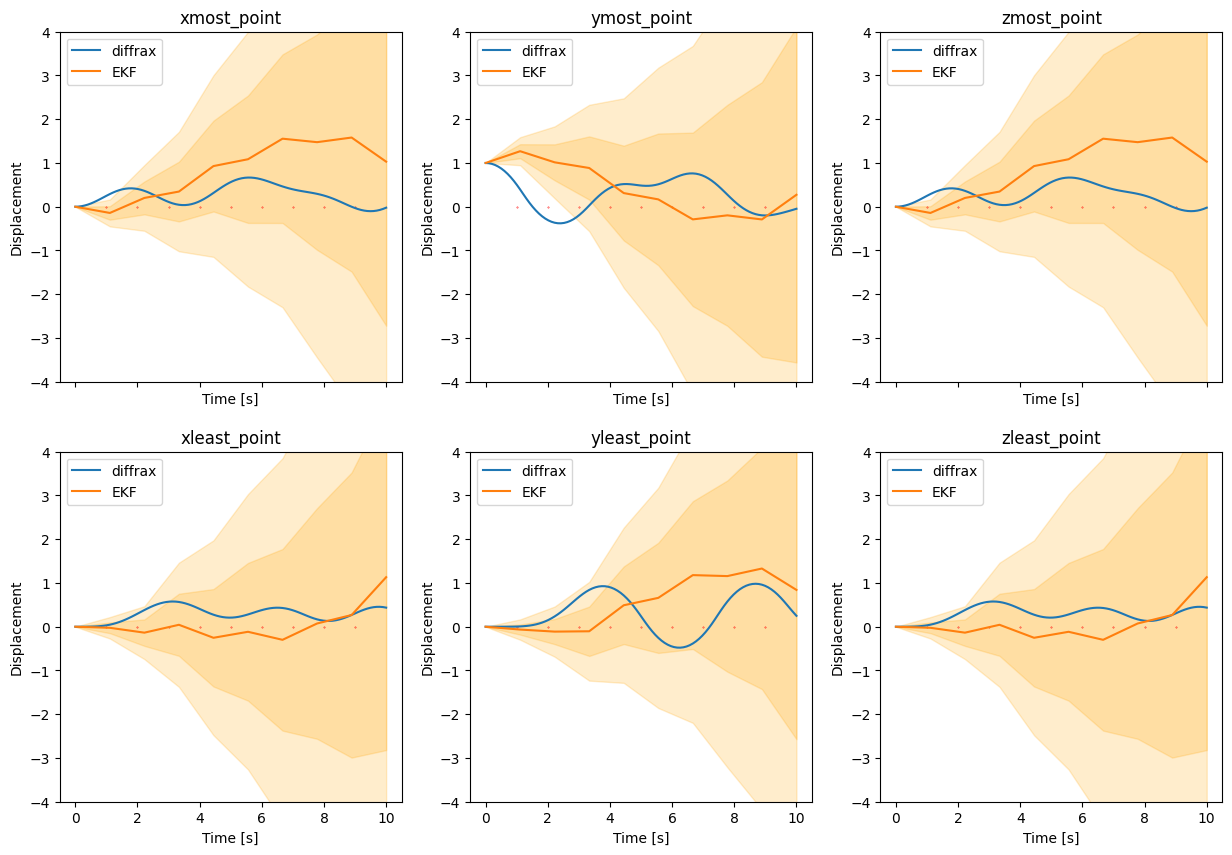

In [4]:
# plot the solution for the six chosen points
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True)

axs[0, 0].plot(sol.ts, diffrax_sol[:, xmost_point], label="diffrax")
axs[0, 1].plot(sol.ts, diffrax_sol[:, ymost_point], label="diffrax")
axs[0, 2].plot(sol.ts, diffrax_sol[:, zmost_point], label="diffrax")
axs[1, 0].plot(sol.ts, diffrax_sol[:, xleast_point], label="diffrax")
axs[1, 1].plot(sol.ts, diffrax_sol[:, yleast_point], label="diffrax")
axs[1, 2].plot(sol.ts, diffrax_sol[:, zleast_point], label="diffrax")

axs[0, 0].set_ylim((-4, 4))
axs[0, 1].set_ylim((-4, 4))
axs[0, 2].set_ylim((-4, 4))
axs[1, 0].set_ylim((-4, 4))
axs[1, 1].set_ylim((-4, 4))
axs[1, 2].set_ylim((-4, 4))

None


def plot_3std(ax, domain, means, stds, color):
    for i in range(1, 3):
        ax.fill_between(
            domain,
            means + i * stds,
            means - i * stds,
            alpha=0.2,
            color=color,
        )


axs[0, 0].plot(domain, kalman_sol[:, xmost_point], label="EKF")
plot_3std(
    axs[0, 0], domain, kalman_sol[:, xmost_point], u_std[:, xmost_point], color="orange"
)

axs[0, 1].plot(domain, kalman_sol[:, ymost_point], label="EKF")
plot_3std(
    axs[0, 1], domain, kalman_sol[:, ymost_point], u_std[:, ymost_point], color="orange"
)

axs[0, 2].plot(domain, kalman_sol[:, zmost_point], label="EKF")
plot_3std(
    axs[0, 2], domain, kalman_sol[:, zmost_point], u_std[:, zmost_point], color="orange"
)

axs[1, 0].plot(domain, kalman_sol[:, xleast_point], label="EKF")
plot_3std(
    axs[1, 0],
    domain,
    kalman_sol[:, xleast_point],
    u_std[:, xleast_point],
    color="orange",
)

axs[1, 1].plot(domain, kalman_sol[:, yleast_point], label="EKF")
plot_3std(
    axs[1, 1],
    domain,
    kalman_sol[:, yleast_point],
    u_std[:, yleast_point],
    color="orange",
)

axs[1, 2].plot(domain, kalman_sol[:, zleast_point], label="EKF")
plot_3std(
    axs[1, 2],
    domain,
    kalman_sol[:, zleast_point],
    u_std[:, zleast_point],
    color="orange",
)

axs[0, 0].set_title("xmost_point")
axs[0, 1].set_title("ymost_point")
axs[0, 2].set_title("zmost_point")
axs[1, 0].set_title("xleast_point")
axs[1, 1].set_title("yleast_point")
axs[1, 2].set_title("zleast_point")

for row in axs:
    for ax in row:
        ax.scatter(
            np.nonzero(update_indicator)[0] * delta_time,
            [0] * np.sum(update_indicator).item(),
            color="red",
            s=0.1,
        )
        ax.set_ylabel("Displacement")
        ax.set_xlabel("Time [s]")
        ax.legend()


In [5]:
import shelve


def set_value(key, value, filename="mydata.db"):
    """Set a value in the persistent dictionary."""
    with shelve.open(filename, writeback=True) as db:
        db[key] = value


def get_value(key, default=None, filename="mydata.db"):
    """Get a value from the persistent dictionary."""
    with shelve.open(filename) as db:
        return db.get(key, default)


def remove_value(key, filename="mydata.db"):
    """Remove a value from the persistent dictionary."""
    with shelve.open(filename, writeback=True) as db:
        if key in db:
            del db[key]
        else:
            print(f"Key '{key}' not found.")


def wipe_db(filename="mydata.db"):
    """Wipe all data from the persistent dictionary."""
    with shelve.open(filename, writeback=True) as db:
        db.clear()


wipe_db("wave.db")

In [6]:
import itertools
import probabilistic_solve_icosphere


def build_experiment_name(prior, derivatives, timesteps):
    return f"{prior}_{derivatives}_{timesteps}"


priors = ["wave", "iwp"]
derivatives = [2, 3, 4]
timesteps = [200, 400, 800, 1200, 1500, 2000][:3]
product = list(itertools.product(priors, derivatives, timesteps))

In [7]:
import time

import rich.progress
import rich

config.update("jax_enable_x64", True)

progress_bar = rich.progress.track(total=len(product), sequence=product)
for prior, q, timestep in progress_bar:
    experiment_name = build_experiment_name(prior, q, timestep)
    print(f"Running experiment: {experiment_name}")

    remove_value(experiment_name, "wave.db")
    means, stds, runtime, rmse = get_value(experiment_name, [None] * 4, "wave.db")
    if means is None:
        start_time = time.time()
        try:
            means, stds = probabilistic_solve_icosphere.solve(
                isosphere_nu=nu,
                timesteps=timestep,
                derivatives=q,
                prior=prior,
            )
            means = means[:, zleast_point]
            stds = stds[:, zleast_point]
        except Exception as err:
            print(f"Experiment {experiment_name} failed because of {err}")
        end_time = time.time()
        diff = means - diffrax_sol[:, zleast_point]
        rmse = jnp.sqrt(jnp.mean(diff**2))
        # save as float32 instead of float64 (jax)
        means = means.astype(np.float32)
        stds = stds.astype(np.float32)
        set_value(
            experiment_name,
            (
                means.astype(np.float32),
                stds.astype(np.float32),
                end_time - start_time,
                rmse,
            ),
            filename="wave.db",
        )
    else:
        continue

Output()

Running experiment: wave_2_200

Key 'wave_2_200' not found.

Running experiment: wave_2_400

Key 'wave_2_400' not found.

Running experiment: wave_2_800

Key 'wave_2_800' not found.

Running experiment: wave_3_200

Key 'wave_3_200' not found.

Running experiment: wave_3_400

Key 'wave_3_400' not found.

Running experiment: wave_3_800

Key 'wave_3_800' not found.

Running experiment: wave_4_200

Key 'wave_4_200' not found.

Running experiment: wave_4_400

Key 'wave_4_400' not found.

Running experiment: wave_4_800

Key 'wave_4_800' not found.

Running experiment: iwp_2_200

Key 'iwp_2_200' not found.

Running experiment: iwp_2_400

Key 'iwp_2_400' not found.

Running experiment: iwp_2_800

Key 'iwp_2_800' not found.

Running experiment: iwp_3_200

Key 'iwp_3_200' not found.

Running experiment: iwp_3_400

Key 'iwp_3_400' not found.

Running experiment: iwp_3_800

Key 'iwp_3_800' not found.

Running experiment: iwp_4_200

Key 'iwp_4_200' not found.

Running experiment: iwp_4_400

Key 'iwp_4_400' not found.

Running experiment: iwp_4_800

Key 'iwp_4_800' not found.

/var/folders/vc/1d1z34l176gfm4swwfttvslr0000gn/T/ipykernel_80658/1309795234.py:4: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  fig.tight_layout(pad=5.0)


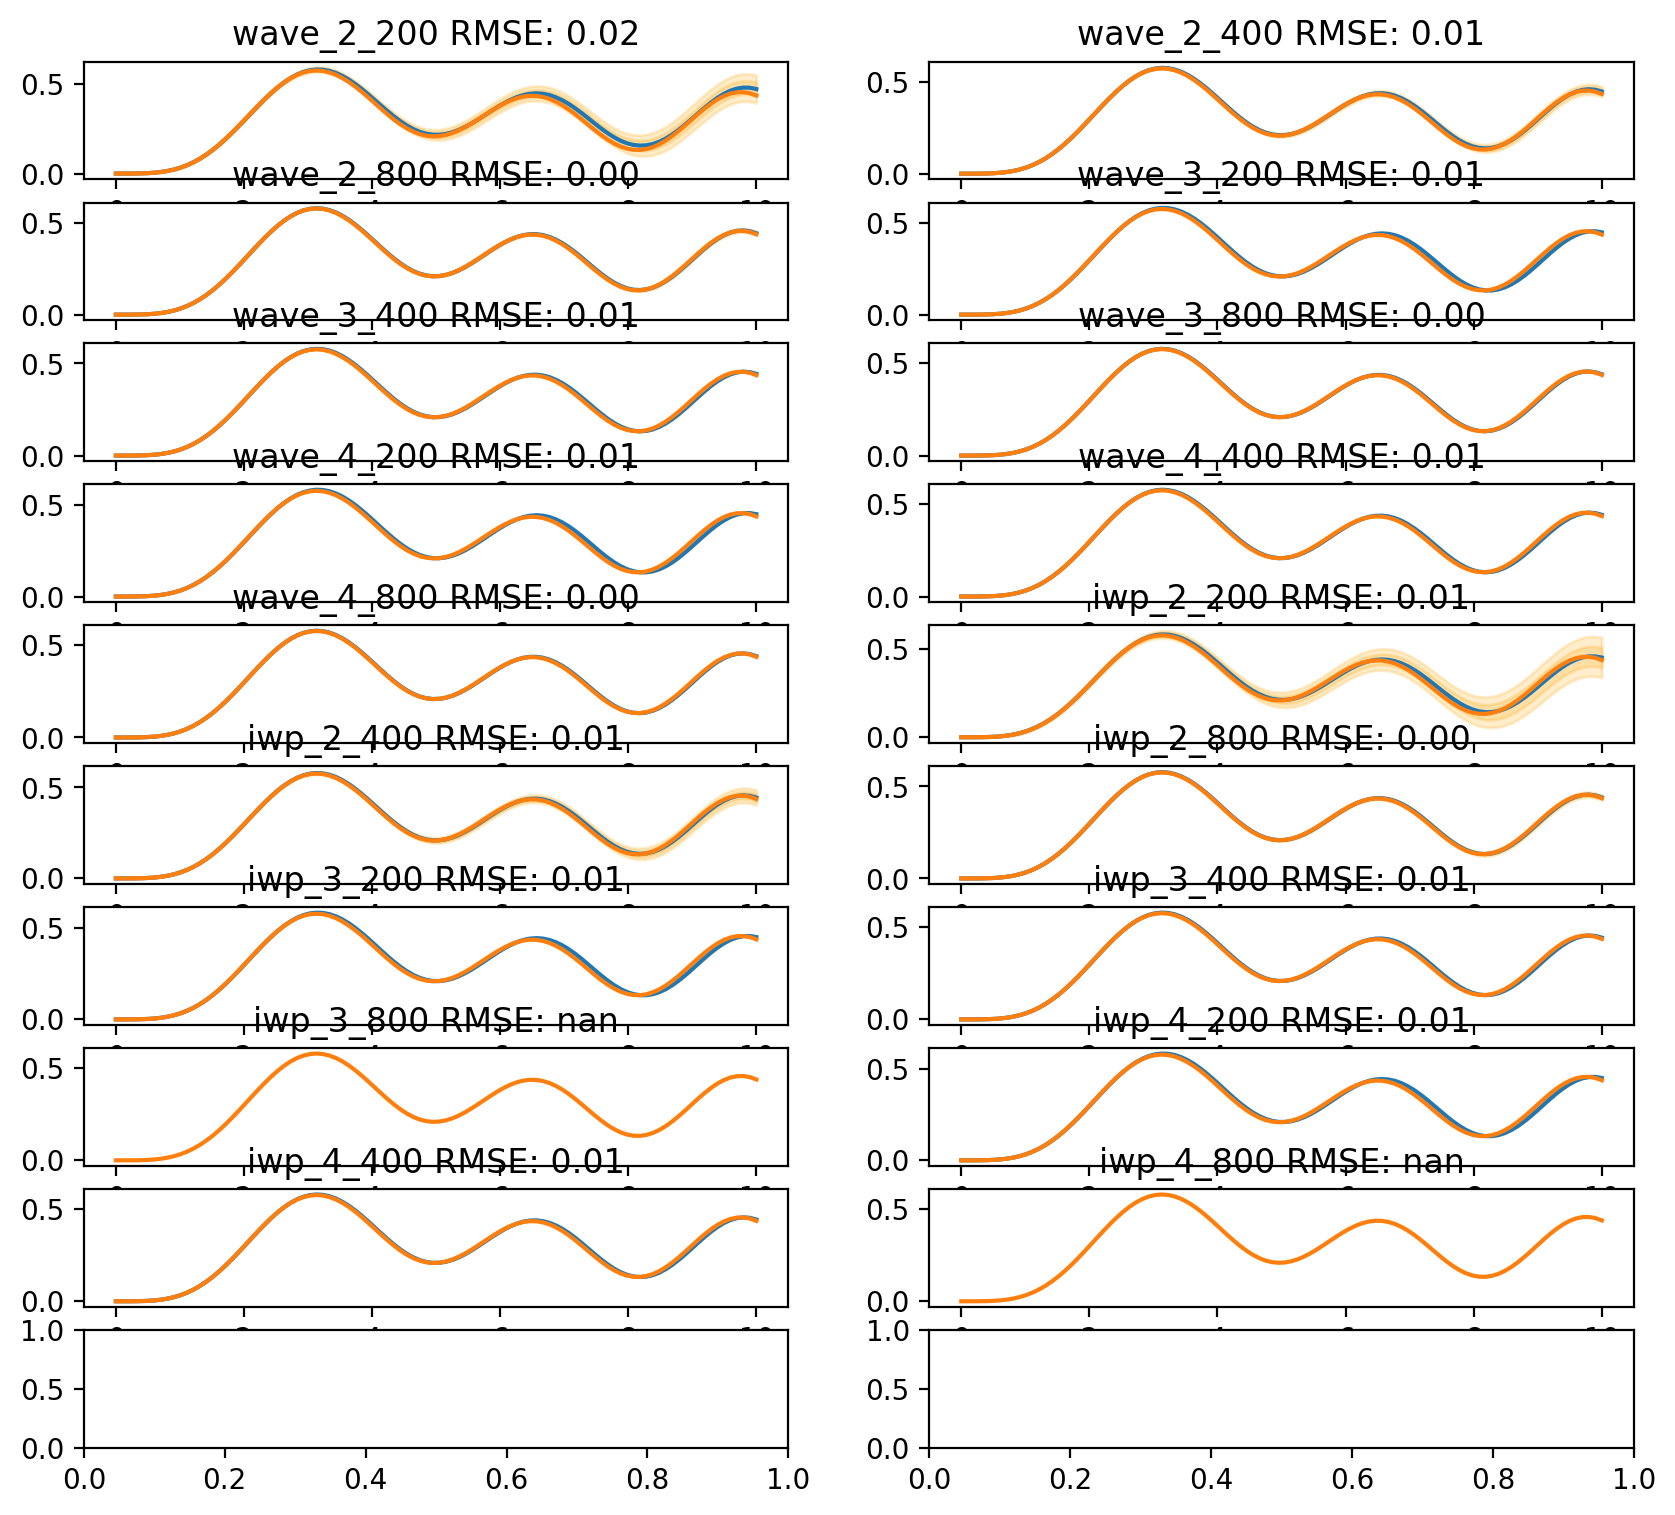

In [8]:
fig, ax = plt.subplots(
    1 + len(product) // 2, 2, dpi=200, figsize=(10, len(product) // 2)
)
fig.tight_layout(pad=5.0)
for i, (prior, q, timestep) in enumerate(product):
    experiment_name = build_experiment_name(prior, q, timestep)
    means, stds, runtime, rmse = get_value(
        f"{prior}_{q}_{timestep}", [None] * 4, "wave.db"
    )
    if means is None:
        continue

    ax.flatten()[i].plot(probabilistic_solve_icosphere.return_times, means, label="EKF")
    plot_3std(
        ax.flatten()[i],
        probabilistic_solve_icosphere.return_times,
        means,
        stds,
        color="orange",
    )

    ax.flatten()[i].plot(sol.ts, diffrax_sol[:, zleast_point], label="diffrax")
    ax.flatten()[i].set_title(f"{experiment_name} RMSE: {rmse:.2f}")

# fig.tight_layout()

''

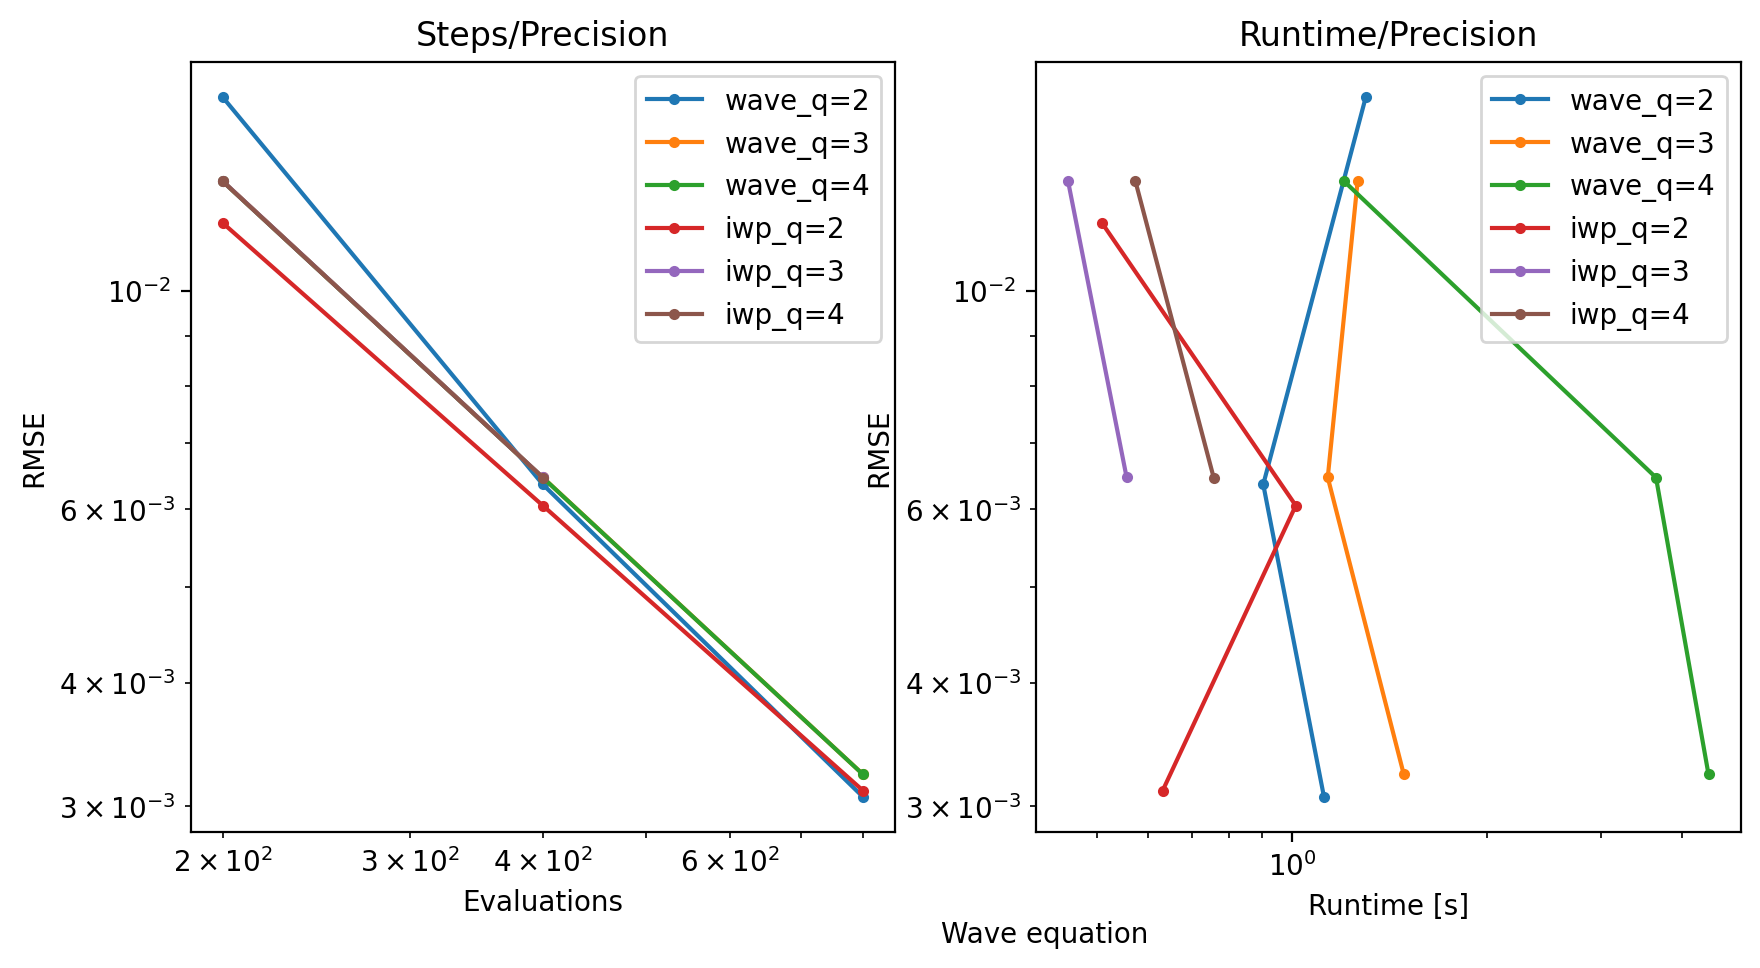

In [9]:
# precision / work plot
fig, (steps_ax, runtime_ax) = plt.subplots(1, 2, dpi=200, figsize=(10, 5))

fig.text(0.5, 0, "Wave equation")

steps_ax.set_title("Steps/Precision")
runtime_ax.set_title("Runtime/Precision")

steps_ax.set_ylabel("RMSE")
steps_ax.set_xlabel("Evaluations")

runtime_ax.set_ylabel("RMSE")
runtime_ax.set_xlabel("Runtime [s]")


for prior in priors:
    for q in derivatives:
        name = f"{prior}_q={q}"
        time_rmse = []
        runtime_rmse = []
        for timestep in timesteps:
            experiment_name = build_experiment_name(prior, q, timestep)
            means, stds, runtime, rmse = get_value(
                f"{prior}_{q}_{timestep}", [None] * 4, "wave.db"
            )
            if means is None or jnp.isnan(means).any():
                continue
            time_rmse.append((timestep, rmse))
            runtime_rmse.append((runtime, rmse))

        steps_ax.plot(*zip(*time_rmse), label=name, marker=".")
        runtime_ax.plot(*zip(*runtime_rmse), label=name, marker=".")

steps_ax.legend()
steps_ax.loglog()
runtime_ax.legend()
runtime_ax.loglog()
;

In [10]:
def hex_to_rgb(hex: str):
    return np.array([int(hex[i : i + 2], 16) for i in (0, 2, 4)])


hex_to_rgb("1f77b4")

array([ 31, 119, 180])

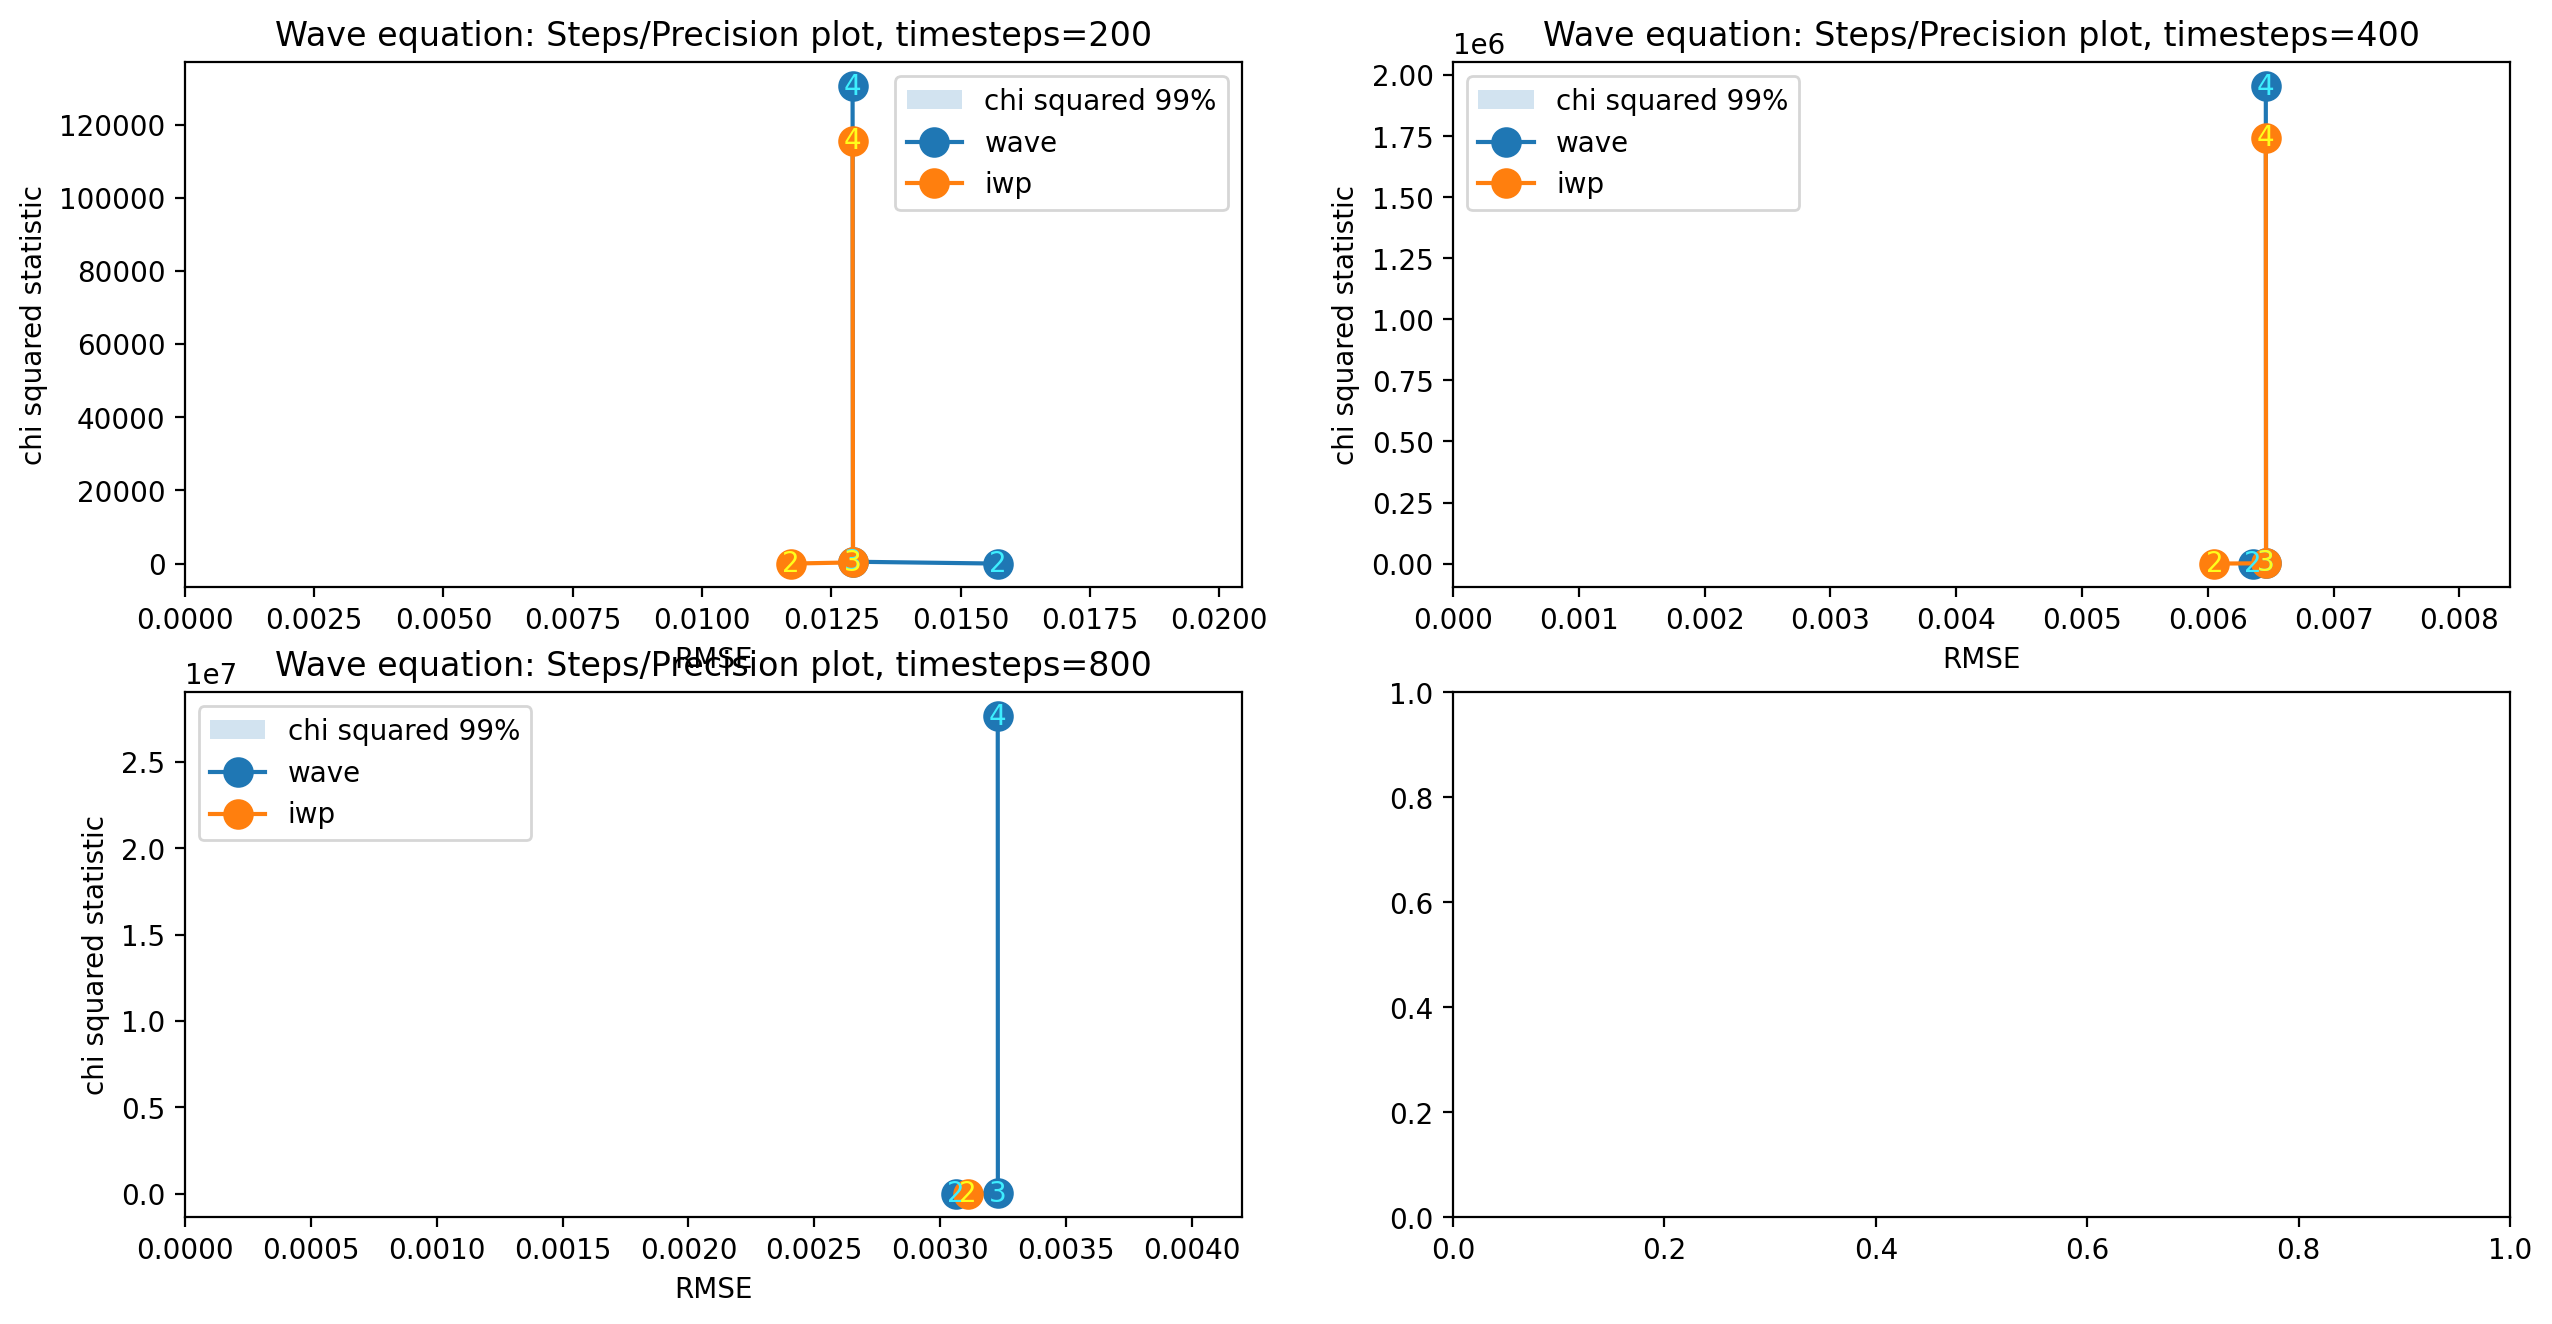

In [11]:
# evalute chi squared statistic
import scipy.stats as stats

# precision / work plot
fig, (ax) = plt.subplots(
    len(timesteps) // 2 + 1, 2, dpi=200, figsize=(15, (len(timesteps) // 2) * 7.5)
)


for axis, timestep in zip(ax.flatten(), timesteps):
    axis.set_title(f"Wave equation: Steps/Precision plot, timesteps={timestep}")

    axis.set_ylabel("chi squared statistic")
    axis.set_xlabel("RMSE")
    end = stats.chi2.ppf(0.99, df=timestep - 1) / (timestep - 1)
    start = stats.chi2.ppf(0.01, df=timestep - 1) / (timestep - 1)

    axis.fill_between(
        [0, 1], [start, start], [end, end], alpha=0.2, label="chi squared 99%"
    )

    all_rmses = []
    for prior in priors:
        name = f"{prior}"
        chi_rmse_q = []
        for q in derivatives:
            experiment_name = build_experiment_name(prior, q, timestep)
            means, stds, runtime, rmse = get_value(
                f"{prior}_{q}_{timestep}", [None] * 4, "wave.db"
            )
            if means is None or jnp.isnan(means).any():
                continue

            diff = means - diffrax_sol[:, zleast_point]
            stat = jnp.sum((diff[1:] / stds[1:]) ** 2) / (timestep - 1)

            end = stats.chi2.ppf(0.99, df=timestep - 1) / (timestep - 1)
            start = stats.chi2.ppf(0.01, df=timestep - 1) / (timestep - 1)
            chi_rmse_q.append((stat, rmse, q))
            all_rmses.append(rmse)

        if chi_rmse_q == []:
            continue
        text_fix = [-0.0, -0]
        last_plot_color = axis.plot(
            [rmse for (_, rmse, _) in chi_rmse_q],
            [(chi) for (chi, _, _) in chi_rmse_q],
            label=name,
            marker="o",
            markersize=10,
        )[-1].get_color()
        for chi, rmse, q in chi_rmse_q:
            axis.text(
                rmse + text_fix[0],
                chi + text_fix[1],
                q,
                horizontalalignment="center",
                verticalalignment="center",
                color=np.clip(hex_to_rgb(last_plot_color[1:]) * 2 / 255, 0, 1),
            )

    axis.set_xlim(0, np.max(all_rmses) * 1.3)
    axis.legend()

In [12]:
list(zip(*((chi, rmse) for (chi, rmse, q) in chi_rmse_q)))

[(Array(0.09822766, dtype=float32),), (Array(0.00310892, dtype=float64),)]